In [19]:
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
# from simulate_data import simulate_data

# 初始化参数
lambda_val = 299792458 / 6.5e9  # 波长
dAntenna = 0.0204  # 天线间距
eps = np.finfo(float).eps
DeltaThetaDeg = [0, 90, 180,270]
# DeltaThetaDeg = [0, 120]

kAntennaPairCount = len(DeltaThetaDeg)

Nab = np.zeros((2, kAntennaPairCount))  # 天线向量
Nab[0, 0] = 0
Nab[1, 0] = dAntenna

kAntennaCount = Nab.shape[1]


for col in range(1, kAntennaPairCount):
    theta = DeltaThetaDeg[col] / 180 * np.pi
    Nab[:, col] = np.dot(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], Nab[:, 0]
    )



# 计算向量和等于零的组合
"zero antenna group"
Index = range(kAntennaPairCount)

for count in range(3, kAntennaPairCount):
    Choose = np.array(list(combinations(Index, count)))

    for row in range(len(Choose)):
        NabSum = np.array([0, 0])

        for col in range(len(Choose[row])):
            NabSum = NabSum + Nab[:, Choose[row][col] - 1]

        if np.all(np.abs(NabSum) < eps):
            chosen_row = Choose[row, :]


In [20]:
import pandas as pd
import json

def load_real_data(file_path):
    # 方法1：手动处理JSON列（100%兼容您的格式）
    with open(file_path, 'r') as f:
        # 读取所有行
        lines = f.readlines()
        
        # 处理表头
        header = lines[0].strip().split(',')
        
        # 处理数据行
        data = []
        for line in lines[1:]:
            # 分割前4个常规字段
            parts = line.strip().split(',', 4)  # 最多分割4次
            if len(parts) == 5:
                # 解析JSON（兼容单/双引号）
                phase_diff = json.loads(parts[4].replace("'", '"'))
                data.append([
                    parts[0],       # timestamp
                    float(parts[1]), # distance(m)
                    float(parts[2]), # azimuth(deg)
                    float(parts[3]), # elevation(deg)
                    phase_diff      # phase_diff (已解析为dict)
                ])
    
    # 转换为DataFrame
    df = pd.DataFrame(data, columns=header)
    
    # 获取所有可能的相位差键（如["1-0", "2-1", "3-2", "0-3"]）
    all_keys = set()
    for x in df['phase_diff']:
        all_keys.update(x.keys())
    all_keys = sorted(all_keys)  # 固定顺序
    
    # 将字典转换为固定长度的数组
    phase_diff_array = np.zeros((len(all_keys), len(df)))
    for i, x in enumerate(df['phase_diff']):
        for j, key in enumerate(all_keys):
            phase_diff_array[j, i] = x.get(key, 0.0)  # 不存在则填0
    
    return (pd.to_datetime(df['timestamp']).values,
            df['distance(m)'].values,
            df['azimuth(deg)'].values,
            df['elevation(deg)'].values,
            phase_diff_array)

def prepare_real_data(file_path, AnchorPos):
    # 加载数据
    timestamps, distances, azimuths, elevations, phase_diffs = load_real_data(file_path)
    
    # 计算真实轨迹（极坐标→笛卡尔坐标）
    TrackTruth = np.zeros((3, len(distances)))
    TrackTruth[0, :] = distances * np.cos(np.deg2rad(elevations)) * np.cos(np.deg2rad(azimuths)) + AnchorPos[0]
    TrackTruth[1, :] = -distances * np.cos(np.deg2rad(elevations)) * np.sin(np.deg2rad(azimuths)) + AnchorPos[1]
    TrackTruth[2, :] = distances * np.sin(np.deg2rad(elevations)) + AnchorPos[2]
    
    # 相位差矩阵 (N_samples × N_antenna_pairs)
    PhiDiff = phase_diffs.T  # 转置为(kAntennaCount, kSampleCount)
    
    return len(distances), TrackTruth, PhiDiff, distances

In [ ]:
# ####################参数设置
disStd = 0.019 * 1.0
phiStd = np.array([12.87, 4.43, 13.79, 6.23]) * np.pi / 180  # 四个天线对的噪声 [rad]
anchorZ = 0.5
AnchorPos = np.array([0, 0, anchorZ])  #基站坐标

dataSource = 1



match dataSource:
    case 0:  # 采用仿真数据
        tagZ = 0.9
        tagHeightRange = 0  # 标签在指定平面上下活动的范围
# ######   标量       标签真实轨迹   真实方位角俯仰角     相位差测量值（含噪声）   距离测量值（含噪声）
        kSampleCount, TrackTruth,    PhiThetaTruth  ,       PhiDiff,              Dis = simulate_data(
            Nab, lambda_val, AnchorPos, tagZ, disStd, phiStd
        )
    case 1:
        kSampleCount, TrackTruth, PhiDiff, Dis = prepare_real_data("../data_818-821/data_820/uwb_data_820_free.csv", AnchorPos)
    case _:
        print("dataSource is invalid! Check and retry.")

PhiDiff_deg = PhiDiff.T
PhiDiff = PhiDiff_deg * np.pi / 180
# print(kSampleCount)
# print(TrackTruth.shape)
# print(PhiDiff)
# print(PhiDiff_deg )
# print(Dis.shape)


##########异常值处理#####################
def remove_abnormal_points(data, abnormal_indices):
    """从数据中删除指定索引的点（兼容一维和二维数组）"""
    abnormal_indices = np.unique(np.sort(abnormal_indices))
    
    # 生成正常点掩码 (True=保留, False=剔除)
    mask = np.ones(data.shape[-1], dtype=bool)  # 取最后一维的长度
    mask[abnormal_indices] = False
    
    # 根据维度选择切片方式
    if data.ndim == 1:
        return data[mask]
    elif data.ndim == 2:
        return data[:, mask]
    else:
        raise ValueError("只支持一维或二维数组！")

for i in range(15):
        # 计算相邻点位移量（阈值设为0.5米）
        delta_pos = np.linalg.norm(TrackTruth[:, 1:] - TrackTruth[:, :-1], axis=0)
        abnormal_indices = np.where(delta_pos > 0.25)[0] + 1  # +1因为差分后索引偏移
        num = len(abnormal_indices)
        # print(num)
        # print("异常点索引:", abnormal_indices)
        TrackTruth = remove_abnormal_points(TrackTruth, abnormal_indices)
        PhiDiff = remove_abnormal_points(PhiDiff, abnormal_indices)
        Dis = remove_abnormal_points(Dis, abnormal_indices)

print(TrackTruth.shape)
print(PhiDiff.shape)
print(Dis.shape)
kSampleCount = TrackTruth.shape[1]
##########异常值处理#####################

from mpl_toolkits.mplot3d import Axes3D
def plt_truth2D():
        plt.figure(figsize=(10, 6))
        plt.plot(TrackTruth[0], TrackTruth[1], 'r-', linewidth=2, label='groundtruth')
        plt.scatter(0, 0, c='green', s=100, marker='*', label='base')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('EKF(2D)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 保证x/y轴比例一致
def plt_truth3D():
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 绘制轨迹
        ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
                'r-', label='Ground Truth', linewidth=2)
  
        # ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
        #         'g--', label='TrackWithDis', linewidth=1.5)

        # 绘制基站
        ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
                c='green', s=200, marker='*', label='Anchor')

        # 美化设置
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('3D Trajectory Comparison')
        ax.legend()
        ax.grid(True)


# plt_truth2D()
# plt_truth3D()

# plt.figure()
# plt.plot(np.arange(1, TrackTruth.shape[1]+1), TrackTruth[0,:], label="Pz")
# plt.legend()

(3, 457)
(4, 457)
(457,)


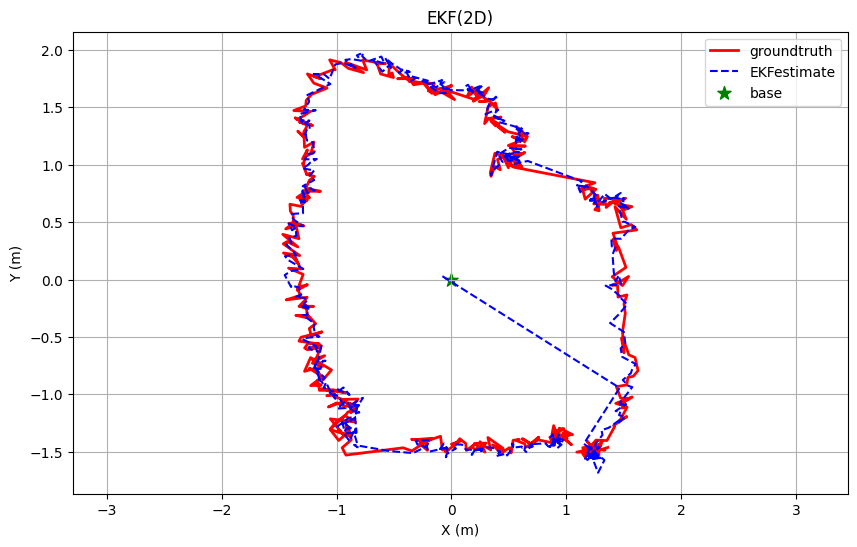

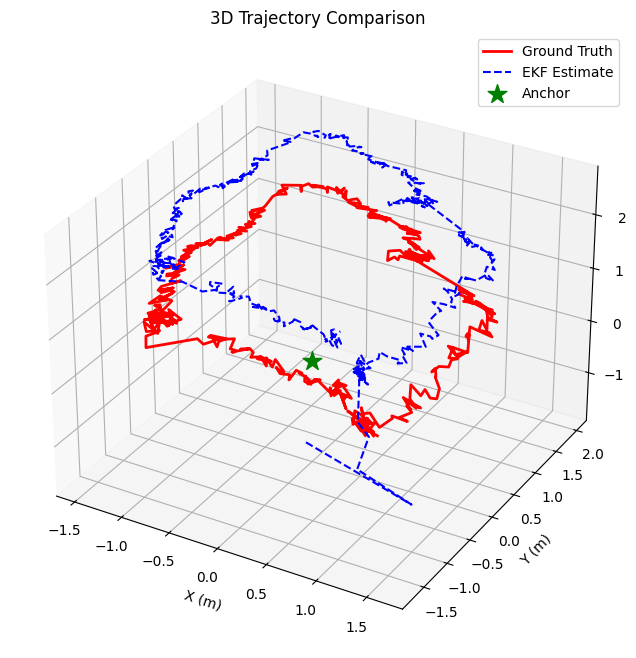

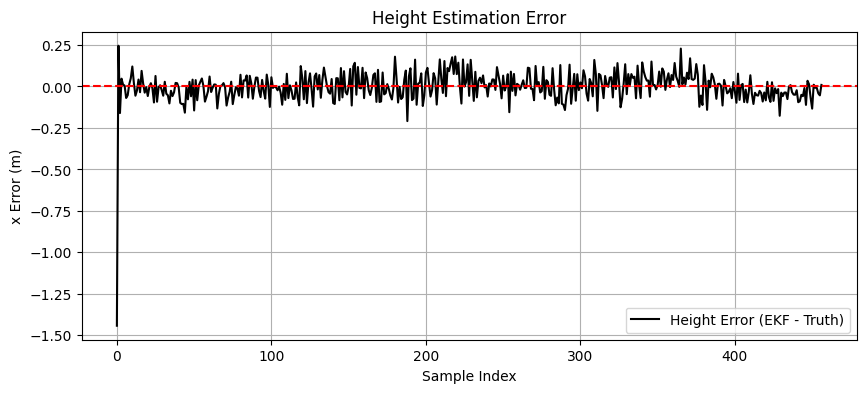

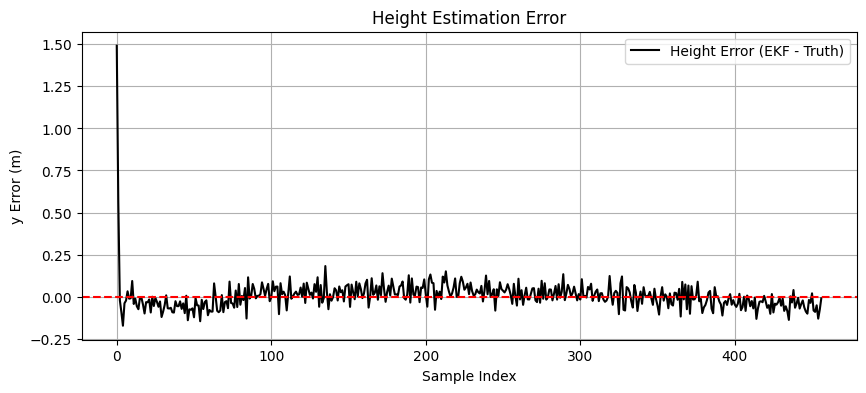

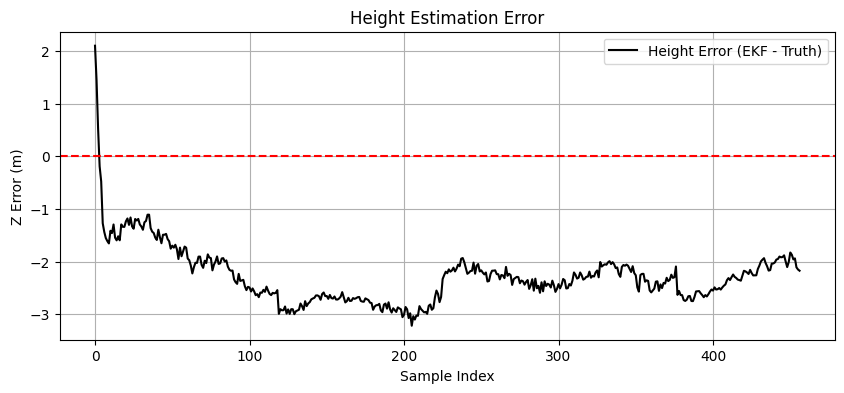

In [25]:
import numpy as np
from scipy.linalg import block_diag
from mpl_toolkits.mplot3d import Axes3D
# 初始状态（假设标签从原点静止启动）
x_init = np.array([0.5, 1.5, 2.0, 0, 0, 0])  # [x, y, z, vx, vy, vz]
P_init = np.diag([0.4,0.4 , 0.04 ,0.3,0.3,0.3 ])  # 初始协方差
# 初始化IMM滤波器
class IMMFilter:
    def __init__(self,sigma_a):

        self.f =self._create_ca_filter(sigma_a)  # 加速度噪声标准差
        # self.f = self._create_cv_filter()
        self.R_phi = np.diag(phiStd ** 2)  # 相位差噪声
        self.R_dis = disStd ** 2                           # 距离噪声
        self.R = np.block([[self.R_phi, np.zeros((kAntennaCount, 1))],
              [np.zeros((1, kAntennaCount)), self.R_dis]])
        
    def _create_cv_filter(self):
        """创建CV模型滤波器（低过程噪声）"""
        Q = np.diag([0.01, 0.08, 0.08, 0.5, 0.5, 0.1])  # 小噪声
        return {'x': x_init.copy(), 'P': P_init.copy(), 'Q': Q}
    def _create_ca_filter(self, sigma_a=0.5):
        """创建CA模型滤波器（高过程噪声）"""
        # CA模型的Q矩阵构造（参见前文公式）
        dt = 1.0 / 10
        q_pos = (dt**4)/4 * sigma_a**2
        q_vel = dt**2 * sigma_a**2
        q_cross = (dt**3)/2 * sigma_a**2
        Q = np.array([
            [q_pos, 0, 0, q_cross, 0, 0],
            [0, q_pos, 0, 0, q_cross, 0],
            [0, 0, q_pos, 0, 0, q_cross],
            [q_cross, 0, 0, q_vel, 0, 0],
            [0, q_cross, 0, 0, q_vel, 0],
            [0, 0, q_cross, 0, 0, q_vel]
        ])
        return {'x': x_init.copy(), 'P': P_init.copy(), 'Q': Q}
    
    def get_F_matrix( self,dt):
        """CV模型基础"""
        return np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
    
    def predict(self, dt):
        """各模型独立预测"""
        F = self.get_F_matrix( dt)  # 状态转移矩阵（CV/CA共用）
        self.f['x'] = F @ self.f['x']
        self.f['P'] = F @ self.f['P'] @ F.T + self.f['Q']
    
    def observation_model(self, x, AnchorPos, Nab, lambda_val):
        pos = x[:3]
        r = np.linalg.norm(pos - AnchorPos)
        
        vTO = AnchorPos - pos
        vTO = (AnchorPos - pos) / r  # 单位方向向量
        PhiDiff_ekf = np.zeros(Nab.shape[1])
        for i in range(Nab.shape[1]):
            vNab = np.array([Nab[0, i], Nab[1, i], 0])  # 天线对向量
            deltaR = np.dot(vTO, vNab)
            PhiDiff_ekf[i] = (2 * np.pi / lambda_val) * deltaR
        
        # 合并观测值
        z = np.concatenate([PhiDiff_ekf, [r]])
        return z
    

    def compute_H(self , x_pred, AnchorPos, Nab, lambda_val, eps=1e-6):
        """数值法计算雅可比矩阵（带防错处理）"""
        H = np.zeros((kAntennaCount + 1, 6))
        h0 = self.observation_model(x_pred, AnchorPos, Nab, lambda_val)
        for i in range(6):
            dx = np.zeros(6)
            dx[i] = eps
            h_eps = self.observation_model(x_pred + dx, AnchorPos, Nab, lambda_val)
            H[:, i] = (h_eps - h0) / eps
        return H
    
    def update(self, z, AnchorPos, Nab, lambda_val):
        """更新步"""
     
        # 计算雅可比矩阵H
        H = self.compute_H(self.f['x'], AnchorPos, Nab, lambda_val)
            
        # 计算卡尔曼增益
        S = H @ self.f['P'] @ H.T + self.R
        K = self.f['P'] @ H.T @ np.linalg.inv(S)
            
        # 更新状态和协方差
        z_pred = self.observation_model(self.f['x'], AnchorPos, Nab, lambda_val)
        innovation = z - z_pred
        self.f['x'] = self.f['x'] + K @ innovation
        self.f['P'] = (np.eye(6) - K @ H) @ self.f['P']
        
        return  self.f['x'], innovation
# 初始化IMM
imm = IMMFilter(12.0)
# 存储结果
TrackEKF = np.full((3, kSampleCount), np.nan)
TrackEKF_residu = np.full((4, kSampleCount), np.nan)
TrackEKF_velocity = np.full((3, kSampleCount), np.nan)

for index in range(kSampleCount):
    dt = 1.0 / 10
    z_meas = np.concatenate([PhiDiff[:, index], [Dis[index]]])
    
    # --- IMM预测步 ---
    imm.predict(dt)
    
    # --- IMM更新步 ---
    x_est, innovation = imm.update(z_meas, AnchorPos, Nab, lambda_val)
    
    # 存储结果
    TrackEKF[:, index] = x_est[:3]
    TrackEKF_residu[:, index] = innovation[:4]
    TrackEKF_velocity[:, index] = x_est[3:6]

    
t = np.arange(kSampleCount) * (1.0 / kSampleCount)  # 时间轴
def plt1():
        plt.figure(figsize=(10, 6))
        plt.plot(TrackTruth[0], TrackTruth[1], 'r-', linewidth=2, label='groundtruth')
        plt.plot(TrackEKF[0], TrackEKF[1], 'b--', linewidth=1.5, label='EKFestimate')
        plt.scatter(AnchorPos[0], AnchorPos[1], c='green', s=100, marker='*', label='base')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('EKF(2D)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 保证x/y轴比例一致
def plt2():
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 绘制轨迹
        ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
                'r-', label='Ground Truth', linewidth=2)
        ax.plot(TrackEKF[0], TrackEKF[1], 1-TrackEKF[2], 
                'b--', label='EKF Estimate', linewidth=1.5)
        # ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
        #         'g--', label='TrackWithDis', linewidth=1.5)

        # 绘制基站
        ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
                c='green', s=200, marker='*', label='Anchor')

        # 美化设置
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('3D Trajectory Comparison')
        ax.legend()
        ax.grid(True)
def plt3():
        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[0] - TrackTruth[0], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('x Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)


        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[1] - TrackTruth[1], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('y Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)

        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[2] - TrackTruth[2], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('Z Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)
plt1()
plt2()
plt3()



In [23]:

# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), TrackEKF_velocity[0,:], label="Vz")
# plt.legend()